# HCC1143 Outlier
During background registration there was an outlier in Round 9, registration error was relatively large compared to other rounds. This notebook is aimed at figuring out why the outlier is occuring.

In [96]:
import sys
sys.path.append('..')

from pandas import read_csv
from IPython.display import display
from imageio import imread
from ipywidgets import interact, Dropdown, fixed, IntSlider
import matplotlib.pyplot as plt
import cv2 as cv

from mpleximreg.utils import parse_tif_dir, normalize_image
from mpleximreg import registration

In [8]:
df = read_csv('../Data_Files/HCC1143_backgroundreg_results.csv')
display(df)

,Registration Method,Target Round,Moving Round,Registration Channel,Dataset,TRE,Mean Error (um)
0,Nonrigid registration - Background,0,R1,2,HCC1143 (OHSU),0.000102,0.829964
1,Nonrigid registration - Background,0,R7,2,HCC1143 (OHSU),0.000163,1.322324
2,Nonrigid registration - Background,0,R5,2,HCC1143 (OHSU),0.000249,2.027702
3,Nonrigid registration - Background,0,R9,2,HCC1143 (OHSU),0.067399,547.974548
4,Nonrigid registration - Background,0,R10,2,HCC1143 (OHSU),0.000119,0.967156
5,Nonrigid registration - Background,0,R4,2,HCC1143 (OHSU),0.000256,2.081179
6,Nonrigid registration - Background,0,R6,2,HCC1143 (OHSU),0.000169,1.377194
7,Nonrigid registration - Background,0,R8,2,HCC1143 (OHSU),0.000179,1.456136
8,Nonrigid registration - Background,0,R11,2,HCC1143 (OHSU),0.000194,1.579560
9,Nonrigid registration - Background,0,R3,2,HCC1143 (OHSU),0.000217,1.763636


In [69]:
# visualize this image rounds before registration
imdir = '/data/hcc1143_unregistered_tifs/'
filenames = parse_tif_dir(imdir)

def show_im(r, c, bins, threshold):
    filepath = filenames[r][c]
    im = imread(filepath)
    im = cv.resize(im, (im.shape[1] // 4, im.shape[0] // 4))
    
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))
    ax[1].hist(im.ravel(), bins=bins)
    
    if threshold >= 0:
        im[im<threshold] = 0
        
    ax[0].imshow(im)
    ax[0].set_title(f'Round {r} and channel {c}')
    plt.show()
    
    
def get_channel(r):
    chdict = filenames[r]
    chs = list(chdict.keys())
    
    value = 2 if 2 in chs else chs[0]
    _ = interact(show_im, r=fixed(r), c=Dropdown(description='Channel: ', options=chs, value=value),
                 bins=IntSlider(continuous_update=False, min=10, max=500, value=100),
                 threshold=IntSlider(continuous_update=False, min=-1, max=25000, value=-1))
    
_ = interact(get_channel, r=Dropdown(description='Round: ', options=list(filenames.keys())))

interactive(children=(Dropdown(description='Round: ', options=(0, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0)…

In [73]:
# visualize this image rounds after the registrations
imdir2 = '/data/hcc1143_backgroundreg_tifs/'
filenames2 = parse_tif_dir(imdir2)

def show_im2(r, c, bins, threshold):
    filepath = filenames2[r][c]
    im = imread(filepath)
    im = cv.resize(im, (im.shape[1] // 4, im.shape[0] // 4))
    
    fig, ax = plt.subplots(ncols=2, figsize=(15,7))
    ax[1].hist(im.ravel(), bins=bins)
    
    if threshold >= 0:
        im[im<threshold] = 0
        
    ax[0].imshow(im)
    ax[0].set_title(f'Round {r} and channel {c}')
    plt.show()
    
    
def get_channel2(r):
    chdict = filenames2[r]
    chs = list(chdict.keys())
    
    value = 2 if 2 in chs else chs[0]
    _ = interact(show_im2, r=fixed(r), c=Dropdown(description='Channel: ', options=chs, value=value),
                 bins=IntSlider(continuous_update=False, min=10, max=500, value=100),
                 threshold=IntSlider(continuous_update=False, min=-1, max=25000, value=-1))
    
_ = interact(get_channel2, r=Dropdown(description='Round: ', options=list(filenames2.keys())))

interactive(children=(Dropdown(description='Round: ', options=(7, 0, 10, 11, 1, 2, 3, 4, 5, 6, 8, 9), value=7)…

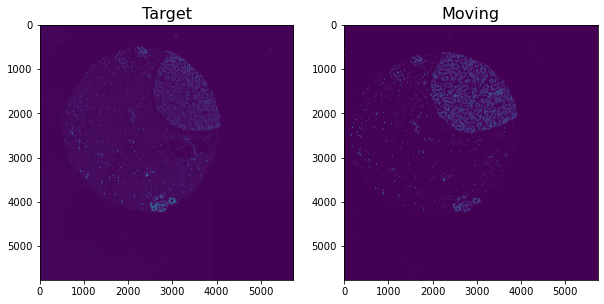

In [107]:
# check out registration error
target = imread(filenames2[0][1])
moving = imread(filenames2[9][1])

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(target)
ax[0].set_title('Target')
ax[1].set_title('Moving')
ax[1].imshow(moving)
plt.show()

In [108]:
target_kpt, target_desc = registration.get_kpts(target)
moving_kpt, moving_desc = registration.get_kpts(moving)

In [109]:
moving_pts, target_pts = registration.match_kpts(target_kpts=target_kpt, target_desc=target_desc,
                                    moving_kpts=moving_kpt, moving_desc=moving_desc)

In [110]:
dist, err = registration.target_registration_error(moving.shape[:2], moving_pts, target_pts)
dist, err

(547.97455, 0.067398734)

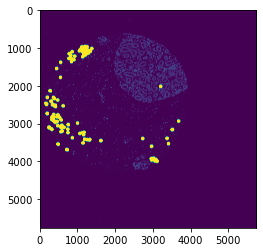

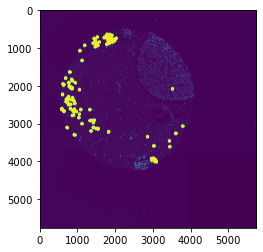

In [111]:
# draw on image
import numpy as np

im = normalize_image(moving).astype(np.uint8)
for pt in moving_pts:
    im = cv.circle(im, (int(pt[0]), int(pt[1])), 50, [255, 0, 0], cv.FILLED)
plt.imshow(im)
plt.show()

im = normalize_image(target).astype(np.uint8)
for pt in target_pts:
    im = cv.circle(im, (int(pt[0]), int(pt[1])), 50, [255, 0, 0], cv.FILLED)

plt.imshow(im)
plt.show()